# Voyages API Use Cases

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [ ]:
pip install signal-ocean

In [1]:
signal_ocean_api_key = '' #replace with your subscription key

## Voyages API Use Cases


In [2]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [3]:
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

### Get voyages

In [4]:
vlcc_id = 84
date_from = date.today() - timedelta(days=180)

In [5]:
voyages = api.get_voyages(vessel_class_id=vlcc_id, date_from=date_from)

In [6]:
voyages = pd.DataFrame(v.__dict__ for v in voyages)
events = pd.DataFrame(e.__dict__ for voyage_events in voyages['events'].dropna() for e in voyage_events)
historical_events = events[events['event_horizon']=='Historical']

In [7]:
def get_voyage_load_area(voyage_events):
    return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)

voyages['load_area'] = voyages['events'].apply(get_voyage_load_area)

In [8]:
def get_voyage_discharge_country(voyage_events):
    return next((e.country for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

voyages['discharge_country'] = voyages['events'].apply(get_voyage_discharge_country)

In [9]:
def get_voyage_load_country(voyage_events):
    return next((e.country for e in voyage_events or [] if e.purpose=='Load'), None)

voyages['load_country'] = voyages['events'].apply(get_voyage_load_country)

### Number of exporting voyages 

In [10]:
voyages_exports_usg = voyages[(voyages['load_area']=='US Gulf')&(voyages['discharge_country']!='United States')]

In [11]:
voyages_exports_usg.shape[0]

88

In [12]:
voyages_exports_usg['discharge_country'].value_counts()

China                               29
Korea, Republic of                  22
India                               20
Taiwan                               7
Thailand                             4
Singapore                            3
Japan                                1
Bonaire, Sint Eustatius and Saba     1
Malaysia                             1
Name: discharge_country, dtype: int64

### Port Delays

In [13]:
discharges_china = historical_events[(historical_events['country']=='China')&(historical_events['purpose']=='Discharge')].copy()
discharges_china['duration'] =  discharges_china['sailing_date'] - discharges_china['arrival_date']

In [14]:
discharges_china['duration'].describe()

count                       553
mean     7 days 05:35:19.598537
std      7 days 17:07:04.185953
min             0 days 02:16:00
25%             3 days 00:00:28
50%             4 days 16:02:23
75%             7 days 23:57:31
max            77 days 14:32:20
Name: duration, dtype: object

In [15]:
discharges_china['duration_in_hours'] = discharges_china['duration'] / np.timedelta64(1, 'h')

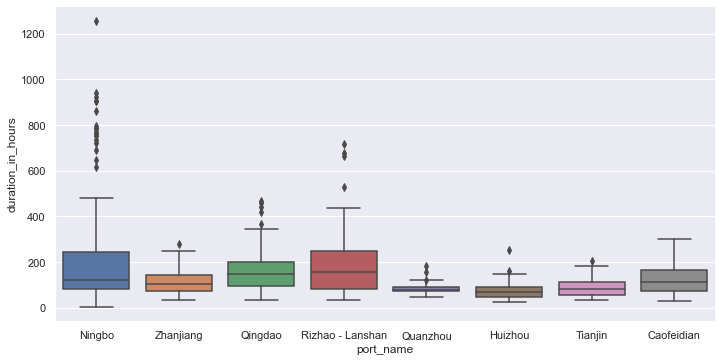

In [16]:
common_discharge_ports_china = discharges_china['port_name'].value_counts().head(8)
common_port_discharges_china = discharges_china[discharges_china['port_name'].isin(common_discharge_ports_china.index)]
sns.catplot(x="port_name", y="duration_in_hours", kind="box", data=common_port_discharges_china, aspect=2);

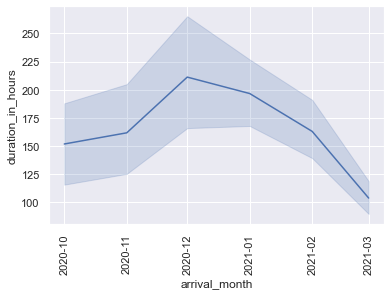

In [17]:
discharges_china['arrival_month'] = discharges_china['arrival_date'].dt.tz_localize(None).dt.to_period('M').dt.to_timestamp()
sns.lineplot(data=discharges_china, x='arrival_month', y='duration_in_hours')
plt.xticks(rotation=90);

### Discharge destinations

In [18]:
discharge_destinations_brazil = voyages[voyages['load_country']=='Brazil'].dropna(subset=['discharge_country'])

In [19]:
discharge_destinations_brazil['discharge_country'].value_counts()

China                 53
India                  3
Korea, Republic of     3
Singapore              1
Name: discharge_country, dtype: int64

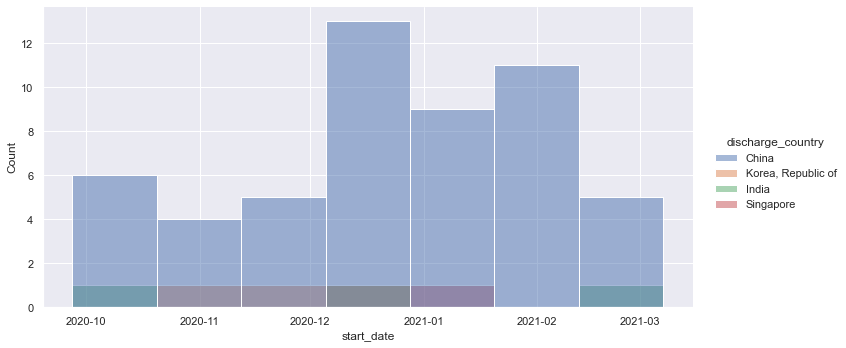

In [20]:
sns.displot(discharge_destinations_brazil, x="start_date", hue="discharge_country", aspect=2);